In [3]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA
from scipy.linalg import expm

In [4]:
def Ωij(rvec,μunit,k0):
    r=np.linalg.norm(rvec)
    x = k0*r
    μdotr = np.dot(μunit,rvec)/r
    μr2 = μdotr**2
    return 3/4*(-(1-μr2)*np.cos(x)/x + 
                 (1-3*μr2)/x**2*(np.sin(x) + np.cos(x)/x) )

In [5]:
def Γij(rvec,μunit,k0):
    r=np.linalg.norm(rvec)
    x = k0*r
    μdotr = np.dot(μunit,rvec)/r
    μr2 = μdotr**2
    return 3/2*( (1-μr2)*np.sin(x)/x + 
                 (1-3*μr2)/x**2*(np.cos(x) - np.sin(x)/x) )

In [6]:
def Hij(rvec,μunit,k0):
    r=np.linalg.norm(rvec)
    x = k0*r
    μdotr = np.dot(μunit,rvec)/r
    μr2 = μdotr**2
    return (3/4)*( -(1-μr2) * np.exp(1j*x)/x + (1-3*μr2)/x**2 * np.exp(1j*x)*( -1j + 1/x ) )

# Two atoms

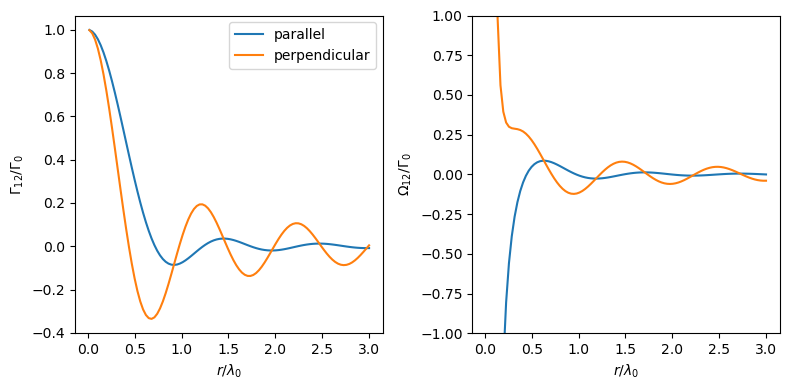

In [7]:
μunit = np.array([1, 0, 0]) # unit direction of dipole moments

k0 = 1.
λ0 = 2*np.pi/k0 # resonance wavelength

Nr = 100
rmax = 3*λ0
r12s = np.linspace(1e-1,rmax,Nr)
runit = np.array([1, 0, 0])

fig, ax = plt.subplots(1,2,figsize=(8,4))

labels=["parallel", "perpendicular"]

for ir, runit in enumerate([ np.array([1,0,0]), np.array([0,1,0]) ]):
    Γ12s = [ Γij(r12*runit,μunit,k0) for r12 in r12s ]
    Ω12s = [ Ωij(r12*runit,μunit,k0) for r12 in r12s ]
    ax[0].plot(r12s/λ0,Γ12s,label=labels[ir])
    ax[1].plot(r12s/λ0,Ω12s,label=labels[ir])

ax[1].set_ylim([-1,1])
for ip in range(2):
    ax[ip].set_xlabel(r"$r/\lambda_0$")
ax[0].set_ylabel(r"$\Gamma_{12}/\Gamma_0$")
ax[1].set_ylabel(r"$\Omega_{12}/\Gamma_0$")
ax[0].legend()
fig.tight_layout()

# $H_\text{eff}$ for $N$ atoms

In [8]:
Natom = 21

In [85]:
# let's put atomic positions in an array

# consider a chain of atoms separated by distance a
a = 0.4*λ0

pos = np.array ( [ n*a for n in range(Natom) ] )

# ssh chain
u = a/10

def pos_ssh_chain(a,u):
    b = a/2 + u*a
    if np.mod(Natom,2)==0:
        return np.array ( [ n*a+ib*b for n in range(Natom//2) for ib in range(2) ] )
    else:
        return np.append( np.array ( [ n*a+ib*b for n in range(Natom//2) for ib in range(2) ] ), (Natom-1)*a/2 )  
        

pos = pos_ssh_chain(a,u)

In [86]:
pos/λ0, len(pos)

(array([0.        , 0.30053096, 0.4       , 0.70053096, 0.8       ,
        1.10053096, 1.2       , 1.50053096, 1.6       , 1.90053096,
        2.        , 2.30053096, 2.4       , 2.70053096, 2.8       ,
        3.10053096, 3.2       , 3.50053096, 3.6       , 3.90053096,
        4.        ]),
 21)

In [87]:
def get_Heff(pos,μunit,runit,k0):
    Natom = len(pos)
    λ0 = 2*np.pi/k0 # resonance wavelength
    rmin = λ0*1e-15

    ΓΓ = [ [ Γij( (np.abs(pos[i1]-pos[i2])+rmin)*runit, μunit, k0) for i1 in range(Natom) ] for i2 in range(Natom) ]
    ΩΩ = [ [ Ωij( (np.abs(pos[i1]-pos[i2])+rmin)*runit, μunit, k0) for i1 in range(Natom) ] for i2 in range(Natom) ]
    

    ΓΓ = np.array( ΓΓ )
    ΩΩ = np.array( ΩΩ )
    
    return ΩΩ - np.diag(np.diag(ΩΩ)) - 1j/2*( ΓΓ- np.diag(np.diag(ΓΓ)) + np.eye(Natom) )

Heff = get_Heff(pos,μunit,runit,k0)

In [88]:
def get_Heff(pos,μunit,runit,k0):
    Natom = len(pos)
    λ0 = 2*np.pi/k0 # resonance wavelength
    
    Heff = np.zeros([Natom,Natom], dtype=complex)
    
    for i1 in range(Natom):
        Heff[i1,i1] = -1j/2
        for i2 in range(i1+1,Natom):
            rvec = np.abs(pos[i1]-pos[i2])*runit
            Heff[i1,i2] = Hij(rvec,μunit,k0)
            Heff[i2,i1] = Heff[i1,i2]
    return Heff

Heff = get_Heff(pos,μunit,runit,k0)

In [89]:
ee, uu = LA.eig(Heff)

IPRs = Natom*np.sum(abs(uu)**4,axis=0)

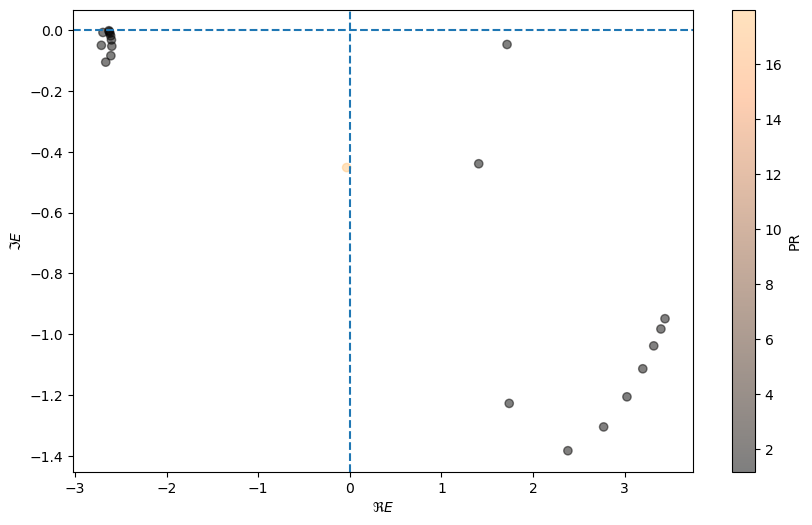

In [90]:
fig, ax = plt.subplots(1,1, figsize=(10,6))

im = ax.scatter(ee.real, ee.imag, c=IPRs, alpha=0.5, cmap='copper')#, vmin=0, vmax=1)
ax.set_xlabel(r'$\Re E$')
ax.set_ylabel(r'$\Im E$')
ax.axhline(y=0, ls='--')
ax.axvline(x=0, ls='--')
#ax.set_title(f'u_0 = {u0}, v_0 = {v0}, drive={drive}, η={η}')
fig.colorbar(im, label='PR',);

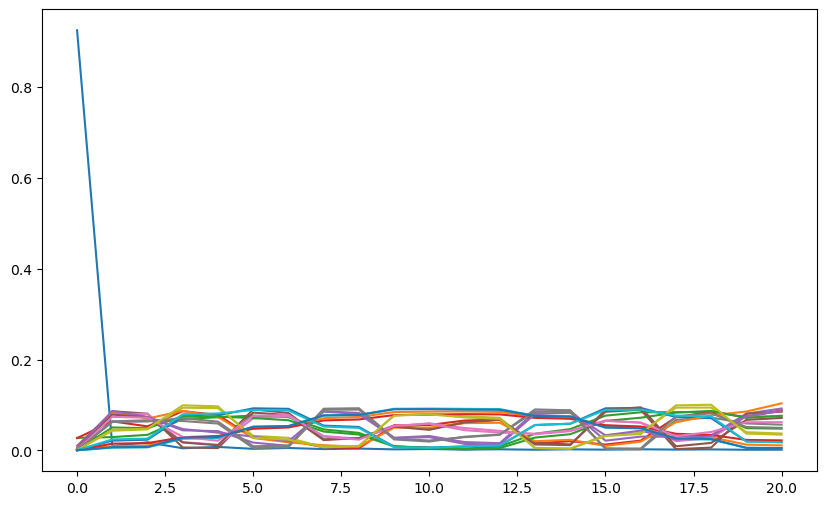

In [91]:
fig, ax = plt.subplots(1,1, figsize=(10,6))

for i in range(Natom):
    ax.plot(abs(uu[:,i])**2)

In [92]:
idxsorted = np.argsort(ee.imag)

In [93]:
istate=-1
ee[idxsorted[istate]]

np.complex128(-2.6299239967401347-0.0009091194934778467j)

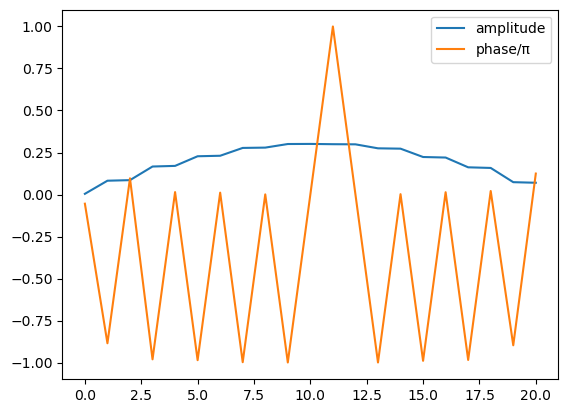

In [94]:
plt.plot(abs(uu[:,idxsorted[istate]]), label="amplitude")
plt.plot(np.angle(uu[:,idxsorted[istate]])/np.pi, label="phase/π")
plt.legend()

In [95]:
abs(uu[:,idxsorted[istate]])

array([0.00410483, 0.08210964, 0.08552078, 0.1665741 , 0.17030219,
       0.22763326, 0.23063182, 0.27722074, 0.27909959, 0.30047995,
       0.30105859, 0.29938847, 0.2986295 , 0.27487282, 0.27283808,
       0.22317157, 0.22001476, 0.16185834, 0.15809299, 0.07342789,
       0.0699523 ])

In [96]:
np.angle(uu[:,idxsorted[istate]])

array([-1.71625190e-01, -2.78094106e+00,  3.02850499e-01, -3.08133085e+00,
        4.51629891e-02, -3.09707108e+00,  3.47982463e-02, -3.13500892e+00,
        2.09950653e-03, -3.14018590e+00,  0.00000000e+00,  3.14142614e+00,
        1.53307025e-03, -3.14014399e+00,  6.29375817e-03, -3.10891078e+00,
        4.29634484e-02, -3.09281988e+00,  6.52070087e-02, -2.81883399e+00,
        3.91655419e-01])

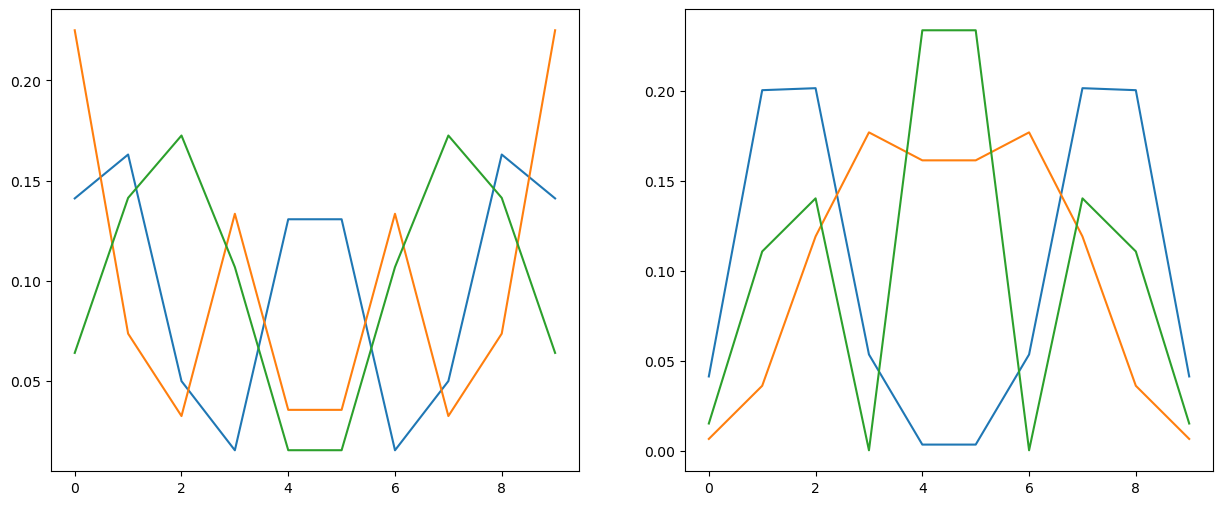

In [30]:
fig, ax = plt.subplots(1,2, figsize=(15,6))

for idx in idxsorted[:3]:
    ax[0].plot(abs(uu[:,idx])**2)
    
for idx in idxsorted[-3:]:
    ax[1].plot(abs(uu[:,idx])**2)

# Spectrum as a function of d/a

In [18]:
%%time
# consider a chain of atoms separated by distance a
a = 0.4*λ0

pos = np.array ( [ n*a for n in range(Natom) ] )

# ssh chain
u = 0.05

uarr = np.linspace(-0.4,0.4)

results = []
for iu, u in enumerate(uarr): 
    pos = pos_ssh_chain(a,u)
    Heff = get_Heff(pos,μunit,runit,k0)
    ee, uu = LA.eig(Heff)
    IPRs = Natom*np.sum(abs(uu)**4,axis=0)
    results.append( [ee,uu,IPRs] )

CPU times: user 6min 6s, sys: 2.12 s, total: 6min 8s
Wall time: 6min 6s


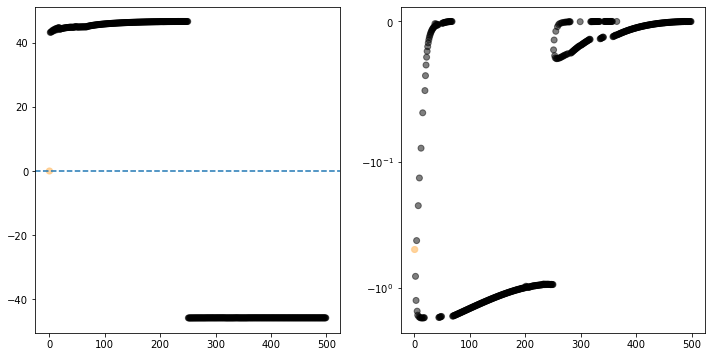

In [19]:
ires = -1
ee,uu,IPRs = results[ires]
fig, ax = plt.subplots(1,2, figsize=(12,6))
im0 = ax[0].scatter(range(Natom), ee.real, c=IPRs, alpha=0.5, cmap='copper')#, vmin=0, vmax=1)
im1 = ax[1].scatter(range(Natom), ee.imag, c=IPRs, alpha=0.5, cmap='copper')#, vmin=0, vmax=1)

ycut = 0.1

ax[1].set_yscale('symlog', linthresh=0.1)
ax[0].axhline(y=-ycut, ls='--')

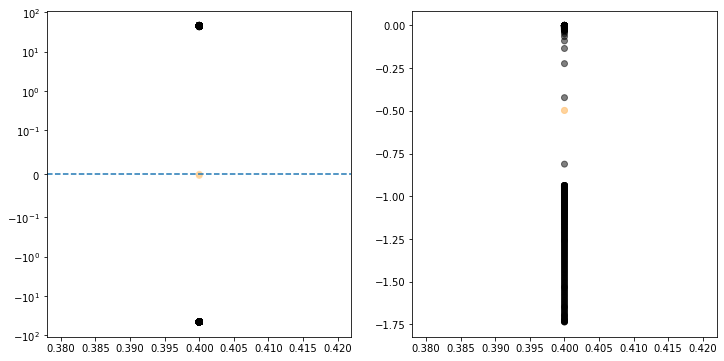

In [20]:
fig, ax = plt.subplots(1,2, figsize=(12,6))

im0 = ax[0].scatter([uarr[ires]]*Natom, ee.real, c=IPRs, alpha=0.5, cmap='copper')#, vmin=0, vmax=1)
im1 = ax[1].scatter([uarr[ires]]*Natom, ee.imag, c=IPRs, alpha=0.5, cmap='copper')#, vmin=0, vmax=1)
ax[0].set_yscale('symlog', linthresh=0.1)
ax[0].axhline(y=0, ls='--')


In [26]:
ee[ ee.imag<-ycut ].real

array([43.28114304, 43.24353877, 43.53004536, 43.43867539, 43.7891817 ,
       43.67084143, 43.99449732, 44.15690656, 43.8555199 , 44.28981369,
       44.40215144, 44.49944784, 44.58535395, 44.66232983, 44.73212507,
       44.79601929, 44.85496976, 44.90972411, 44.96085831, 45.00884791,
       45.05406431, 45.09682999, 45.13739723, 45.17599583, 45.21280422,
       45.24799277, 45.28169174, 45.31403161, 45.34510994, 45.37502939,
       45.40386456, 45.43169806, 45.45858796, 45.48460202, 45.50978609,
       45.5341967 , 45.55787049, 45.58085529, 45.60318071, 45.62488771,
       45.64600044, 45.66655437, 45.68656933, 45.70607637, 45.72509185,
       45.74364317, 45.76174396, 45.77941853, 45.79667828, 45.81354498,
       45.83002818, 45.84614748, 45.86191092, 45.87733625, 45.89243025,
       45.90720906, 45.92167842, 45.93585308, 45.9497379 , 45.96334641,
       45.97668273, 45.98975932, 46.00257969, 46.01515533, 46.02748921,
       46.03959201, 46.05146623, 46.06312178, 46.0745608 , 46.08

In [68]:
IPRs>2

array([ True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

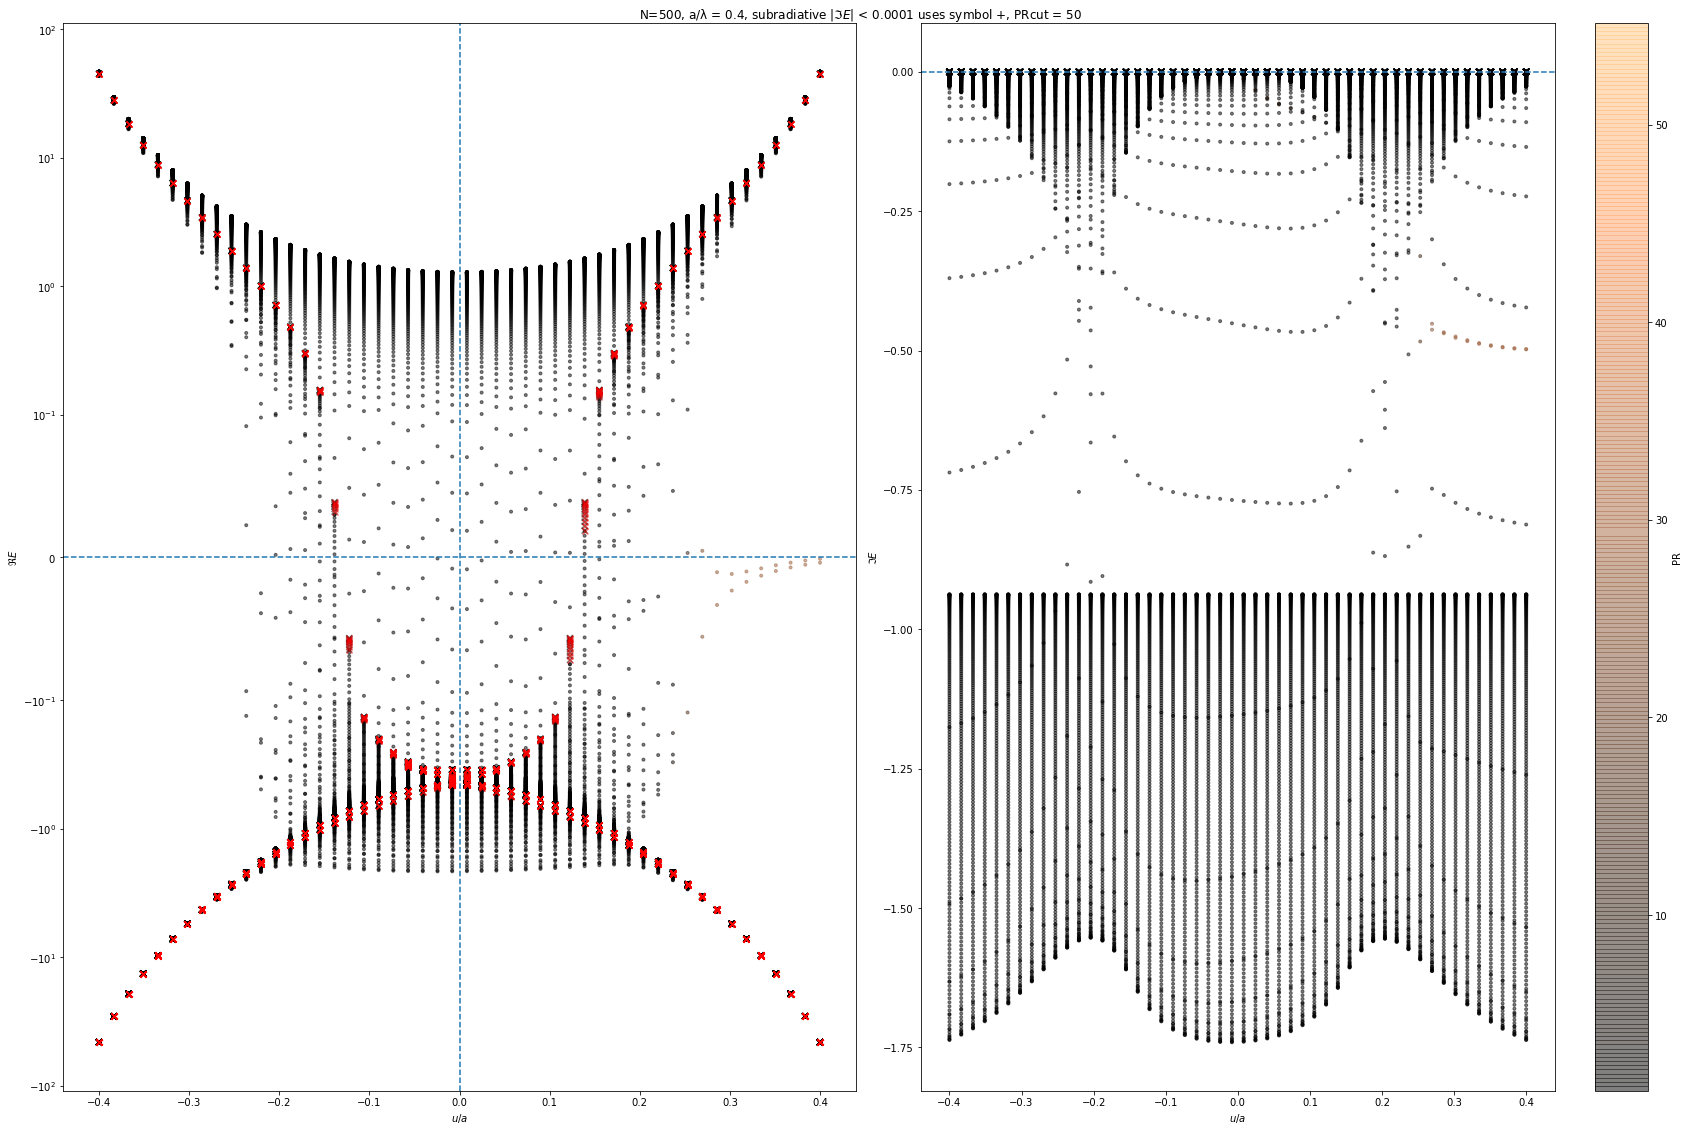

In [85]:
fig, ax = plt.subplots(1,2, figsize=(24,16))

ax[0].set_xlabel(r'$u/a$')
ax[0].set_ylabel(r'$\Re E$')
ax[0].axhline(y=0, ls='--')
ax[0].axvline(x=0, ls='--')
ax[0].set_yscale('symlog', linthresh=.1)

ax[1].set_xlabel(r'$u/a$')
ax[1].set_ylabel(r'$\Im E$')

ycut = 0.0001
ax[1].axhline(y=-ycut, ls='--')

PRcut = 50

for ires, res in enumerate(results):
    ee,uu,IPRs = res
    im0 = ax[0].scatter([uarr[ires]]*len(ee[ee.imag<-ycut]), ee[ee.imag<-ycut].real, marker='.', c=IPRs[ee.imag<-ycut], alpha=0.5, cmap='copper', vmin=0, vmax=Natom)
    im1 = ax[1].scatter([uarr[ires]]*len(ee[ee.imag<-ycut]), ee[ee.imag<-ycut].imag, marker='.', c=IPRs[ee.imag<-ycut], alpha=0.5, cmap='copper', vmin=0, vmax=Natom)
    if len(ee[ee.imag>-ycut]) > 0:
        im0 = ax[0].scatter([uarr[ires]]*len(ee[ee.imag>-ycut]), ee[ee.imag>-ycut].real, marker='x', c=IPRs[ee.imag>-ycut], alpha=0.5, cmap='copper', vmin=0, vmax=Natom)
        im0 = ax[0].scatter([uarr[ires]]*len(ee[ee.imag>-ycut]), ee[ee.imag>-ycut].real, marker='x', c='r', alpha=0.5, cmap='copper', vmin=0, vmax=Natom)
        im1 = ax[1].scatter([uarr[ires]]*len(ee[ee.imag>-ycut]), ee[ee.imag>-ycut].imag, marker='x', c=IPRs[ee.imag>-ycut], alpha=0.5, cmap='copper', vmin=0, vmax=Natom)
    #if len(ee[IPRs>PRcut]) > 0:    
    #    im0 = ax[0].scatter([uarr[ires]]*len(ee[IPRs>PRcut]), ee[IPRs>PRcut].real, marker='.', c='magenta', alpha=0.5)

fig.colorbar(im, label='PR',);
    
fig.suptitle(f'N={Natom}, a/λ = {a/λ0}, subradiative $|\Im E|$ < {ycut} uses symbol +, PRcut = {PRcut}')

fig.tight_layout()

# Time-evolution of an edge excitation

In [310]:
ψ0 = np.zeros(Natom)
#ψ0[Natom//2] = 1
ψ0[-1] = 1 

In [311]:
tmax = 1
Nt = 150
tlist = np.linspace(0,tmax,Nt)

ψts = []
for t in tlist:
    ψt = expm(-1j*Heff*t) @ ψ0
    ψts.append(ψt)
    
ψts = np.array(ψts)

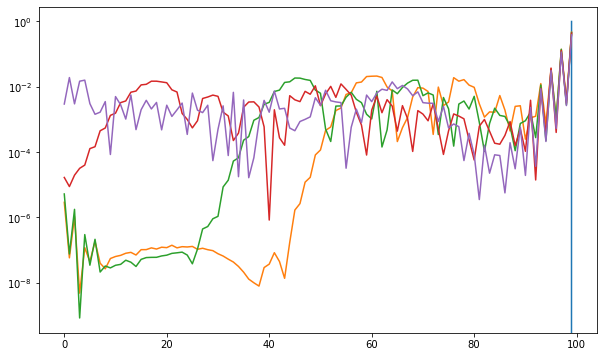

In [312]:
fig, ax = plt.subplots(1,1, figsize=(10,6))

ax.semilogy(abs(ψ0)**2)
for it in [Nt//4, Nt//3, Nt//2, -1]:
    ψt = ψts[it,:]
    ax.semilogy(abs(ψt)**2)

<ipython-input-313-36b6c6e6106b>:3: RuntimeWarning: divide by zero encountered in log
  plt.pcolormesh(np.log(abs(ψts)))


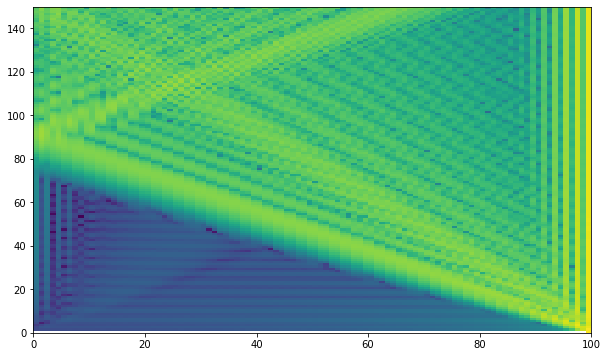

In [313]:
fig, ax = plt.subplots(1,1, figsize=(10,6))

plt.pcolormesh(np.log(abs(ψts)))